In [308]:
#* Import and settings
from os import path

import numpy as np
from scipy.optimize import curve_fit
import sympy as sp
from sympy import Symbol as S
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from lab_tools import graph, lab_round

%matplotlib widget

width = 469.75502 # To get the page width insert "\the\textwidth" in your LaTeX document
here_path = path.abspath('') # path.dirname(__file__)
graph_path = path.join(here_path, "../images/")
data_path = path.join(here_path, "../data/")

mpl.rcParams.update({
    # Show minor ticks
    "ytick.minor.visible": True,
    "xtick.minor.visible": True,
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 11,
    "font.size": 11,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    # High resolution .png
    "savefig.dpi": 600,
    # Default image size
    "figure.figsize": graph.size(width),
})

### Variables

Variables that can be controlled

In [309]:
WAVE_LENGTH = 650 / 10**9

SLIT = 0.02 / 10**3
SLIT_POSITION = 4 / 10**2

SENSOR_SLIT = 1.0 / 10**3
SENSOR_POSITION = 102.5 / 10**2

Derivative variables

In [310]:
distance = SENSOR_POSITION - SLIT_POSITION

# Simulation
Theoretic formula

In [311]:
I_theta_expr = S('I_0') * sp.Pow(
    sp.sinc(
        sp.pi * S('a') / S(r'\lambda') * sp.sin(
            S(r'\theta')
        )
    ),
    2
)
display(sp.Eq(
    S(r'I(\theta)'), I_theta_expr
))

Eq(I(\theta), I_0*sinc(pi*a*sin(\theta)/\lambda)**2)

In [312]:
theta_x_expr = sp.atan(S('x') / S('L'))
display(sp.Eq(
    S(r"\theta(x)"), theta_x_expr
))

Eq(\theta(x), atan(x/L))

In [313]:
I_x_expr = I_theta_expr.subs({S(r'\theta'): theta_x_expr})
display(sp.Eq(
    S(r'I(x)'), I_x_expr
))

Eq(I(x), I_0*sinc(pi*a*x/(L*\lambda*sqrt(1 + x**2/L**2)))**2)

Graph of $I(x)$

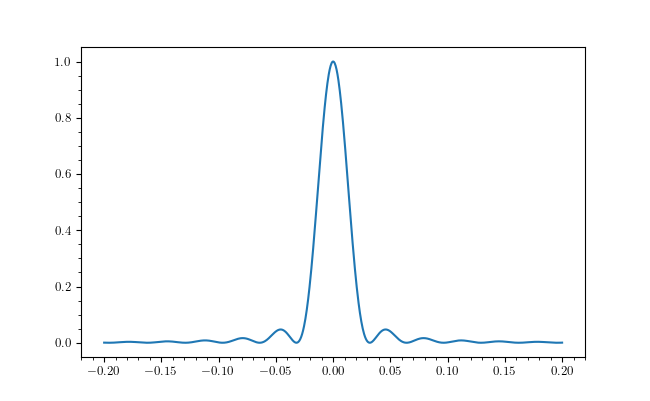

In [314]:
x = np.linspace(-0.2, 0.2, 1000)
I_x = sp.lambdify(
    [S('x')],
    I_x_expr.subs({
        S('I_0'): 1,
        S('a'): SLIT,
        S(r'\lambda'): WAVE_LENGTH,
        S('L'): distance,
    }
))

fig, ax = plt.subplots(1, 1)
ax.plot(x, I_x(x))

# Data analysis

List of files divided by (slit, sensor slit)

In [315]:
filenames = {
    (0.02 / 10**3, 1.5 / 10**3): [
        "Antonio 0.02 1.5.tsv",
        "Antonio 2 0.02 1.5.tsv",
        "Arianna 0.02 1.5.tsv",
        "Florinda 0.02 1.5.tsv",
    ],
    (0.04 / 10**3, 1.5 / 10**3): [
        "Antonio 0.04 1.5.tsv",
        "Matteo 0.04 1.5.tsv",
        "Florinda 0.04 1.5.tsv",
    ],
    (0.08 / 10**3, 1.5 / 10**3): [
        "Arianna 0.08 1.5.tsv",
        "Matteo 0.08 1.5.tsv",
        "Florinda 0.08 1.5.tsv",
    ],
    (0.02 / 10**3, 1.0 / 10**3): [
        "Florinda 0.02 1.0 candela.tsv",
    ],
    (0.04 / 10**3, 1.0 / 10**3): [
        "Antonio 0.04 1.0 candela.tsv",
        "Matteo 0.04 1.0.tsv",
    ],
    (0.08 / 10**3, 1.0 / 10**3): [
        "Arianna 0.08 1.0 candela.tsv",
    ],
}

print("Files for the current configuration:",
      filenames.get((SLIT, SENSOR_SLIT)))

Files for the current configuration: ['Florinda 0.02 1.0 candela.tsv']


Reading all the file for the corresponding configuration

In [316]:
df_list = [
    pd.read_csv(
        data_path + filename,
        sep=r"\t",
        engine="python",
        skiprows=1,
        names=["t", "I", "x"],
    ) for filename in filenames[(SLIT, SENSOR_SLIT)]
]

print(len(df_list), "files read")

1 files read


Minimum and maximum position registered

In [317]:
min_position = [np.min(df.x) for df in df_list]
print("Position min:", min_position)
max_position = [np.max(df.x) for df in df_list]
print("Position max:", max_position)

Position min: [-0.3414]
Position max: [3.75e-05]


Minimum light intensity registered

In [318]:
min_light_intensity = [np.min(df.I) for df in df_list]
print("Minimum measured light:", min_light_intensity)

Minimum measured light: [0.62993]


Position and light intensity of the data peak

In [319]:
peak_index = [np.argmax(df.I) for df in df_list]

peak_position = [df.x[i] for i, df in zip(peak_index, df_list)]
print("The maximum brightness is at position:", peak_position)
print("With an avegare position:", np.mean(peak_position))

peak_light_intensity = [df.I[i] for i, df in zip(peak_index, df_list)]
print("The maximum brightness is:", peak_light_intensity)
print("With an average light intensity:", np.mean(peak_light_intensity))

The maximum brightness is at position: [-0.1854]
With an avegare position: -0.1854
The maximum brightness is: [92.58449]
With an average light intensity: 92.58449


Scatter the data of all the sets

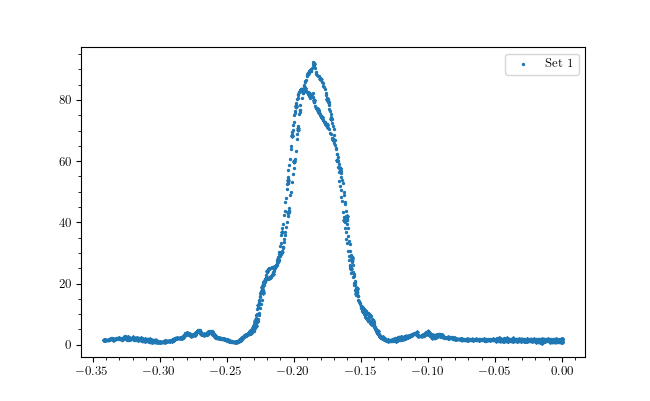

In [320]:
for i, df in enumerate(df_list):
    fig, ax = plt.subplots(1, 1)
    ax.scatter(df.x, df.I, s=2, label=f"Set {i + 1}")
    ax.legend()

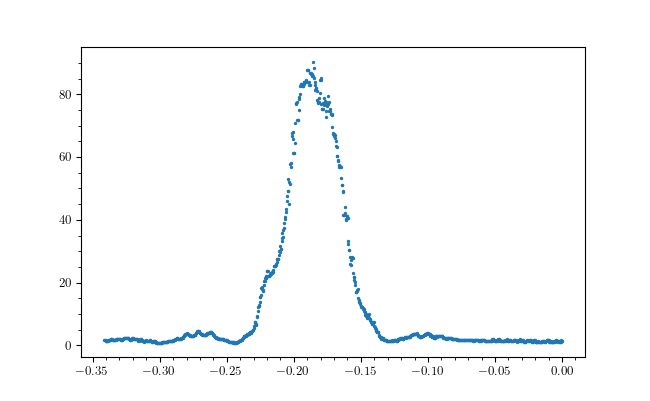

In [321]:
x = np.linspace(
    np.min(min_position),
    np.max(max_position),
    1000
)

I_mean = [
    np.mean([
        np.mean(df.I[np.abs(df.x - i) < SENSOR_SLIT / 2]) for df in df_list
    ])
    for i in x
]

fig, ax = plt.subplots(1, 1)
ax.scatter(x, I_mean, s=2)

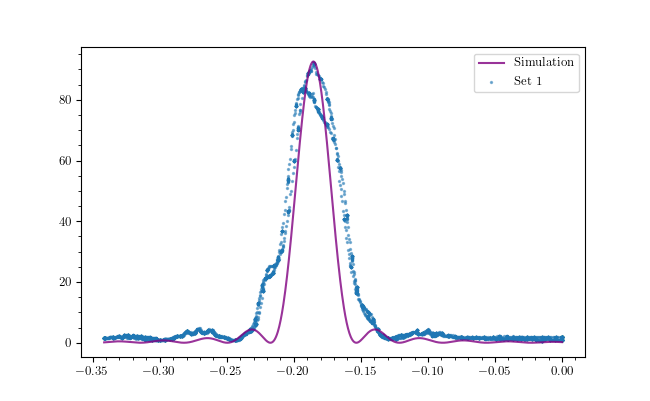

In [322]:
fig, ax = plt.subplots(1, 1)

x = np.linspace(
    np.min(min_position),
    np.max(max_position),
    1000
)
ax.plot(x, I_x(x - np.mean(peak_position)) * np.mean(peak_light_intensity), label="Simulation", color="purple", alpha=0.8)

for i, df in enumerate(df_list):
    ax.scatter(df.x, df.I, s=2, label=f"Set {i + 1}", alpha=0.5)

ax.legend()

# Compare data and simulation results

Create a function similar to the theoretical one with some fit parameter

$\gamma \equiv$ scale, $c \equiv$ shift

In [323]:
I_theta_expr_fit = S('I_0') * sp.Pow(
    sp.sinc(
        sp.pi * S('a') / S(r'\lambda') * sp.sin(
            S(r'\theta')
        )
    ),
    2
)
display(sp.Eq(
    S(r'I(\theta)'), I_theta_expr_fit
))

theta_x_expr_fit = sp.atan(
    (S('x') + S('c')) * S(r'\gamma') / S('L')
)
display(sp.Eq(
    S(r"\theta(x)"), theta_x_expr_fit
))

I_x_expr_fit = I_theta_expr_fit.subs({S(r'\theta'): theta_x_expr_fit})
display(sp.Eq(
    S(r'I(x)'), I_x_expr_fit
))

Eq(I(\theta), I_0*sinc(pi*a*sin(\theta)/\lambda)**2)

Eq(\theta(x), atan(\gamma*(c + x)/L))

Eq(I(x), I_0*sinc(pi*\gamma*a*(c + x)/(L*\lambda*sqrt(1 + \gamma**2*(c + x)**2/L**2)))**2)

Fixed scale factor

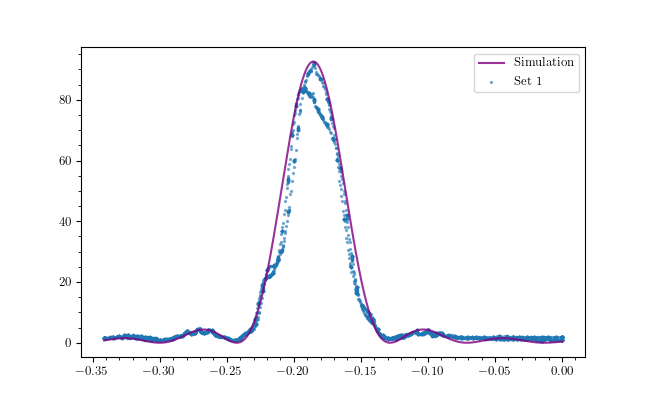

In [329]:
shift = - np.mean(peak_position)
scale = 0.56

I_x_expected = sp.lambdify(
    [S('x')],
    I_x_expr_fit.subs({
        S('I_0'): np.mean(peak_light_intensity),
        S('a'): SLIT,
        S(r'\lambda'): WAVE_LENGTH,
        S('L'): distance,
        S(r'\gamma'): scale,
        S('c'): shift,
    })
)

fig, ax = plt.subplots(1, 1)

x = np.linspace(
    np.min(min_position),
    np.max(max_position),
    1000
)
ax.plot(x, I_x_expected(x), label="Simulation", color="purple", alpha=0.8)

for i, df in enumerate(df_list):
    ax.scatter(df.x, df.I, s=2, label=f"Set {i + 1}", alpha=0.5)

ax.legend()

Fit scale factor

Scale set 1: 0.6273570149542698 +/- 0.0011966009807239336
Scale mean: 0.6273570149542698 +/- 0.0011966009807239336


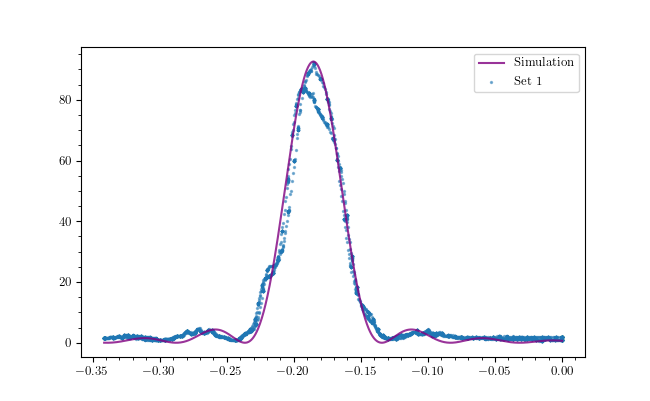

In [325]:
I_x_fit = sp.lambdify(
    [S('x'), S(r'\gamma')],
    I_x_expr_fit.subs({
        S('I_0'): np.mean(peak_light_intensity),
        S('a'): SLIT,
        S(r'\lambda'): WAVE_LENGTH,
        S('L'): distance,
        S('c'): shift,
    })
)

scale_list = []
scale_err_list = []
for i, df in enumerate(df_list):
    (scale, ), pcov = curve_fit(I_x_fit, df.x, df.I, [scale])
    scale_err,  = np.sqrt(np.diag(pcov))
    scale_list.append(scale)
    scale_err_list.append(scale_err)
    print(f"Scale set {i + 1}:", scale, "+/-", scale_err)

scale = np.mean(scale_list)
scale_err = np.mean(scale_err_list)
print(f"Scale mean:", scale, "+/-", scale_err)

I_x_expected = sp.lambdify(
    [S('x')],
    I_x_expr_fit.subs({
        S('I_0'): np.mean(peak_light_intensity),
        S('a'): SLIT,
        S(r'\lambda'): WAVE_LENGTH,
        S('L'): distance,
        S(r'\gamma'): scale,
        S('c'): shift,
    })
)

fig, ax = plt.subplots(1, 1)

x = np.linspace(
    np.min(min_position),
    np.max(max_position),
    1000
)
ax.plot(x, I_x_expected(x), label="Simulation", color="purple", alpha=0.8)

for i, df in enumerate(df_list):
    ax.scatter(df.x, df.I, s=2, label=f"Set {i + 1}", alpha=0.5)

ax.legend()

# Rumore

In [326]:
noise_df = pd.read_csv(
    data_path + "Rumore s lampadina.tsv",
    # data_path + "Laser rumore costante sole.tsv",
    sep=r"\t",
    engine="python",
    skiprows=1,
    names=['t', 'I', 'x'],
)

noise_df.I = noise_df.I / 2

noise_df.head()

,t,I,x
0,0.00,0.045640,0.0
1,0.05,0.045670,0.0
2,0.10,0.045655,0.0
3,0.15,0.045675,0.0
4,0.20,0.045670,0.0


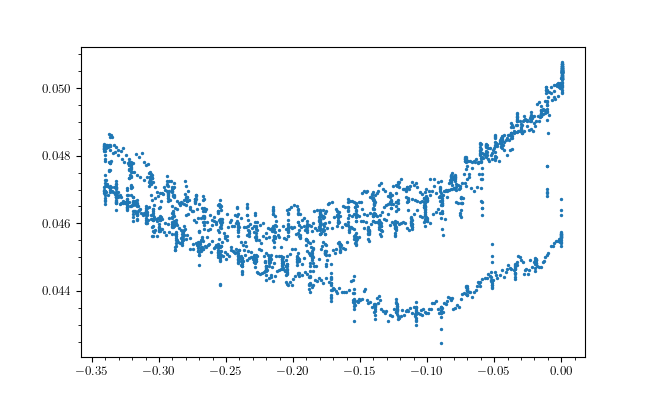

In [327]:
fig, ax = plt.subplots(1, 1)
ax.scatter(noise_df.x, noise_df.I, s=2)

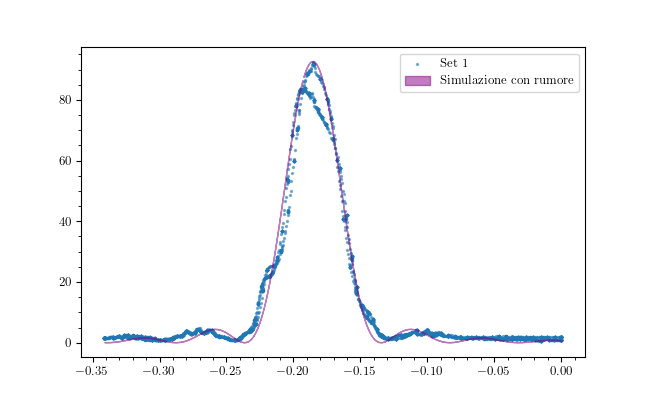

In [328]:
x = np.linspace(
    np.min(noise_df.x),
    np.max(noise_df.x),
    1000
)

I_noise = [
    np.mean(
        noise_df.I[
            np.abs(noise_df.x - i) < SENSOR_SLIT / 2
        ]
    )
    for i in x
]

fig, ax = plt.subplots(1, 1)

for i, df in enumerate(df_list):
    ax.scatter(df.x, df.I, s=2, label=f"Set {i + 1}", alpha=0.5)

ax.fill_between(x, I_x_expected(x), I_x_expected(x) + I_noise, alpha = 0.5, label = "Simulazione con rumore", color="purple")
ax.legend()